In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import sys
sys.path.append("./code")#You may have to alter this, depending on where you are running your notebook server.

In [10]:
from data import uniread
import data.dataset as unimorph_dataset

In [11]:
#We haven't settled on a mapping of languages and families yet...
#So in this example, it's hardcoded as the last parameters.

engdev = uniread.read_unimorph_tsv("/sigmorphon2020/task0-data/germanic/eng.dev",1,1)
germdev = uniread.read_unimorph_tsv("/sigmorphon2020/task0-data/germanic/deu.dev",1,2)


In [12]:
import data.alphabets as alphabets

master_alpha = alphabets.get_master_alphabet()
master_alpha_with_upper = master_alpha + alphabets.Alphabet(str(master_alpha).upper())

In [13]:
ds = unimorph_dataset.pandas_to_dataset([engdev[:100], germdev[:100]],
                                        alphabet_converter_in=master_alpha_with_upper,
                                        alphabet_converter_out=master_alpha_with_upper)

In [14]:
dl = unimorph_dataset.UnimorphDataLoader(ds,batch_size=5,collate_type="pack")

In [16]:
from utils.rnns import *
from utils.seq import *

import torch
import torch.nn as nn

In [17]:
#Just to see if we can have it spit out the same characters as input, no actual recurrence

class No_RNN_Autoencoder(torch.nn.Module):
    def __init__(self,N_SYMBOLS_IN, N_SYMBOLS_OUT):
        super(No_RNN_Autoencoder,self).__init__()
        self.N_SYMBOLS_IN = N_SYMBOLS_IN
        self.N_SYMBOLS_OUT = N_SYMBOLS_OUT
        self.N_hidden = 30
        self.D_embed = N_SYMBOLS_IN 
        
        self.everything = RNN_Layers(
            RNN_Input_Embedding( nn.Embedding(N_SYMBOLS_IN,self.D_embed,padding_idx=0) )
            , RNN_FFLayer(nn.Linear(self.D_embed,N_SYMBOLS_OUT))
            , RNN_FFLayer(nn.Softmax(dim=-1))
        )
    
    def forward(self, some_data):
        return self.everything(some_data.lemma)

In [18]:
model = No_RNN_Autoencoder(len(master_alpha_with_upper),len(master_alpha_with_upper))
#model.everything[0].ff.weight = torch.nn.Parameter(1000*torch.eye(len(master_alpha_with_upper)))
#model.everything[1].ff.weight = torch.nn.Parameter(1000*torch.eye(len(master_alpha_with_upper)))
#model.everything[1].ff.bias = torch.nn.Parameter(torch.zeros(len(master_alpha_with_upper)))

In [19]:
import torch.optim

opt = torch.optim.SGD(model.parameters(),lr=10.0)

letter_classes = torch.eye(len(master_alpha_with_upper))
lossfunc = lambda pred,gt: ((pred.data - letter_classes[gt.data])**2).mean()

In [ ]:
for j in range(1000):#epochs
    
    model.train()
    for i in dl:
        inputs, targets = i
        
        output, hidden = model.forward(inputs)
        #loss = lossfunc(output,targets.form)
        loss = lossfunc(output,inputs.lemma)#autoencoder, not proper model

        loss.backward()

        opt.step() #One step of the optimizer, adjusts parameters.
        opt.zero_grad() #Zeros out the gradient for the next batch?
    
    if j%10 == 0:
        model.eval()
        inputs, targets = dl.collate_fn(dl.dataset)
        output, hidden = model.forward(inputs)
        loss = lossfunc(output,inputs.lemma)#autoencoder, not proper model
        print(loss)


tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)


In [13]:
model.eval()
inputs, targets = dl.collate_fn(dl.dataset)
output, hidden = model.forward(inputs.lemma)

In [14]:
import pylab

Text(0.5, 1.05, 'Differences')

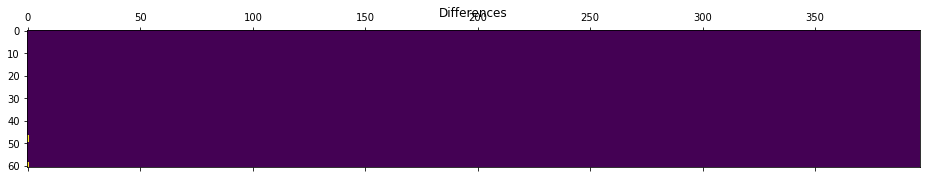

In [15]:
pylab.matshow(((output.data - letter_classes[inputs.lemma.data])**2).detach().numpy())
pylab.title("Differences")

Text(0.5, 1.05, 'Predictions')

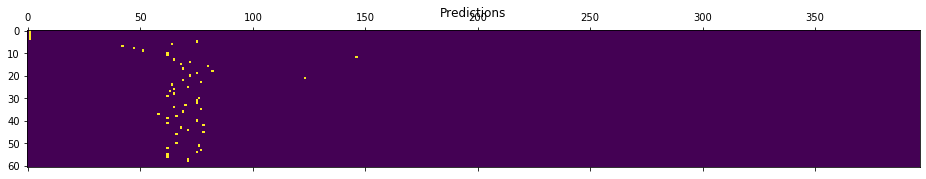

In [16]:
pylab.matshow(((output.data).detach().numpy()))
pylab.title("Predictions")

Text(0.5, 1.05, 'Ground Truth')

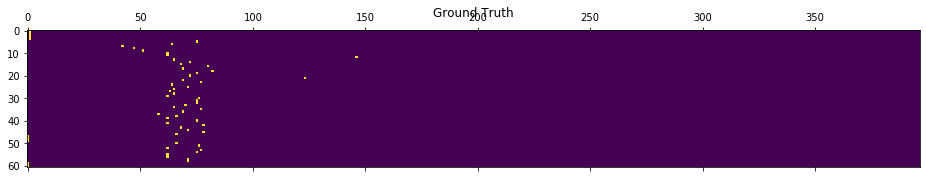

In [17]:
pylab.matshow(((letter_classes[inputs.lemma.data]).detach().numpy()))
pylab.title("Ground Truth")

In [ ]:
import glob